Notebook to work out RL2 eval script to run on MASSIVE

In [1]:
import metaworld
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import warnings

# stop warnings
warnings.filterwarnings('ignore')

# from models import encoder, policy
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
## get the model
RUN_FOLDER = './logs/logs_ML10-v2/rl2_73__28:10_14:11:29'
policy_net = torch.load(RUN_FOLDER + '/models/policy.pt')
encoder_net = torch.load(RUN_FOLDER + '/models/encoder.pt')

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from environments.parallel_envs import make_vec_envs
from utils import helpers as utl

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def evaluate_rl2(
        env_name,
        policy,
        iter_idx,
        encoder,
        num_episodes,
        num_processes,
        num_explore = None,
        deterministic = False
        ):
    
    if num_explore is None:
        num_explore = num_episodes + 1

    # --- set up the things we want to log ---

    # for each process, we log the returns during the first, second, ... episode
    # (such that we have a minimum of [num_episodes]; the last column is for
    #  any overflow and will be discarded at the end, because we need to wait until
    #  all processes have at least [num_episodes] many episodes)
    returns_per_episode = torch.zeros((num_processes, num_episodes + 1)).to(device)
    success_for_episode = torch.zeros((num_processes, num_episodes + 1)).to(device)

    # --- initialise environments and latents ---

    envs = make_vec_envs(env_name,
                         seed=73 * 42 + iter_idx,
                         num_processes=num_processes,
                         gamma=0.99,
                         device=device,
                         rank_offset=num_processes + 1,  # to use diff tmp folders than main processes
                         episodes_per_task=num_episodes,
                         normalise_rew=False,
                         ret_rms=None,
                         tasks=None,
                         add_done_info=True,
                         )

    num_steps = envs._max_episode_steps
    print(f"Max episode steps = {num_steps}")

    # reset environments
    state = envs.reset().float().to(device)#utl.reset_env(envs, args)

    # this counts how often an agent has done the same task already
    task_count = torch.zeros(num_processes).long().to(device)

    # reset latent state to prior
    _, latent_mean, latent_logvar, hidden_state = encoder.prior(num_processes)

    for episode_idx in range(num_episodes):

        ## reset hidden state after exploration episodes
        if episode_idx > num_explore:
            print(episode_idx, "resetting hidden to adapted hidden state")
            fake_dones = torch.zeros(num_processes).to(device)
            encoder.reset_hidden(adapted_hidden, fake_dones)

        for step_idx in range(num_steps):

            with torch.no_grad():
                latent = torch.cat((latent_mean, latent_logvar), dim=-1).squeeze()
                _, action = policy.act(None, latent, None, None, deterministic=deterministic)

            # observe reward and next obs
            state, reward, done, infos = envs.step(action.detach())
            
            # handles case where we normalise rewards
            if isinstance(reward, list):
                reward = reward[0].to(device)
            else:
                reward = reward.to(device)

            # save stuff from info
            done_mdp = [info['done_mdp'] for info in infos]
            successes = torch.tensor([info['success'] for info in infos]).to(device)


            # update the hidden state
            _, latent_mean, latent_logvar, hidden_state = utl.update_encoding(encoder=encoder,
                                                                              next_obs=state,
                                                                              action=action,
                                                                              reward=reward,
                                                                              done=None,
                                                                              hidden_state=hidden_state)
            
            # saves hidden state after initial exploration (-1 because zero index)
            if episode_idx == (num_explore - 1):
                adapted_hidden = hidden_state.clone()

            # get successes
            success_for_episode[range(num_processes), task_count] += successes.view(-1)
            # add rewards
            returns_per_episode[range(num_processes), task_count] += reward.view(-1)

            for i in np.argwhere(done_mdp).flatten():
                # count task up, but cap at num_episodes + 1
                task_count[i] = min(task_count[i] + 1, num_episodes)  # zero-indexed, so no +1
            if np.sum(done) > 0:
                state = envs.reset().float().to(device)

    envs.close()

    # normalise to 1/0
    success_for_episode /= (success_for_episode + 1.0e-10)

    return returns_per_episode[:, :num_episodes], success_for_episode[:, :num_episodes]

In [67]:
rewards, successes = evaluate(
    'ML10-v2',
    policy=policy_net,
    ret_rms = False,
    iter_idx=1,
    tasks = None,
    encoder=encoder_net,
    num_episodes=10,
    num_processes = 10,
    num_explore=None
)

Max episode steps = 500


In [68]:
rewards2, successes2 = evaluate(
    'ML10-v2',
    policy=policy_net,
    ret_rms = False,
    iter_idx=2,
    tasks = None,
    encoder=encoder_net,
    num_episodes=10,
    num_processes = 10,
    num_explore=None
)

Max episode steps = 500


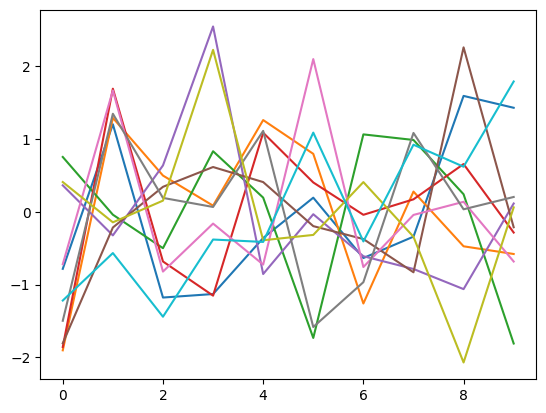

In [70]:
rwds = rewards.detach().cpu().numpy().T 
norm_rwds = (rwds - np.mean(rwds, axis = 0)) / np.std(rwds, axis =0)
plt.plot(
    range(10),norm_rwds
);

In [60]:
rewards.mean(dim=1)

tensor([ 718.0455,   20.6157,    6.8623,  348.9952, 1192.6138,  462.1845,
           8.6920,  155.1655,   58.7877,    9.9283], device='cuda:0')

In [72]:
successes2.mean(dim=1).detach().cpu().numpy()

array([0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. ], dtype=float32)

In [73]:
train_tasks = list(ml10.train_classes.keys())
results1 = clean_results(train_tasks, successes, rewards)
results2 = clean_results(train_tasks, successes2, rewards2)

In [93]:
def combine_results(task_list, rewards, successes):

    reward_df = pd.DataFrame(
        rewards.detach().cpu().numpy().tolist(),
        index = train_tasks
        )\
        .melt(
            var_name='episode',
            value_name = 'mean_rewards',
            ignore_index=False
        ).reset_index().rename(columns = {'index':'tasks'})
    
    success_df = pd.DataFrame(
        successes.detach().cpu().numpy().tolist(),
        index = train_tasks
        )\
        .melt(
            var_name='episode',
            value_name = 'successes',
            ignore_index=False
        ).reset_index().rename(columns = {'index':'tasks'})
    
    return reward_df.merge(success_df, on=['tasks','episode'])
    

In [95]:
results1 = combine_results(train_tasks, rewards, successes)
results2 = combine_results(train_tasks, rewards2, successes2)

In [ ]:
def plot_results(combined_results, log_dir, file_name):
    fig, ax = plt.subplots(figsize = (15, 7))

    # show the range of rewards
    reward_plot = sns.lineplot(
        data = combined_results,
        x = 'episode',
        y = 'mean_rewards',
        hue = 'tasks',
    )

    # add red dots to successful runs
    successes = sns.scatterplot(
        data = combined_results.query('successes==1'),
        x = 'episode',
        y = 'mean_rewards',
        legend = False,
        c = 'red',
        s = 50,
        alpha = 0.75
    )
    fig.savefig(f'{log_dir}/{file_name}.png')
    

In [128]:
print(
    "training results:\n",
    df.loc[:, ['tasks', 'mean_rewards', 'successes']].groupby('tasks').mean(),
'\n===================')


training results:
                          mean_rewards  successes
tasks                                           
basketball-v2               17.277191       0.00
button-press-topdown-v2    338.931758       0.00
door-open-v2               367.378493       0.00
drawer-close-v2            241.097449       0.05
peg-insert-side-v2          11.369244       0.00
pick-place-v2                7.321946       0.00
push-v2                     21.804567       0.00
reach-v2                   821.087027       0.00
sweep-v2                    58.348057       0.00
window-open-v2             143.757415       0.00 


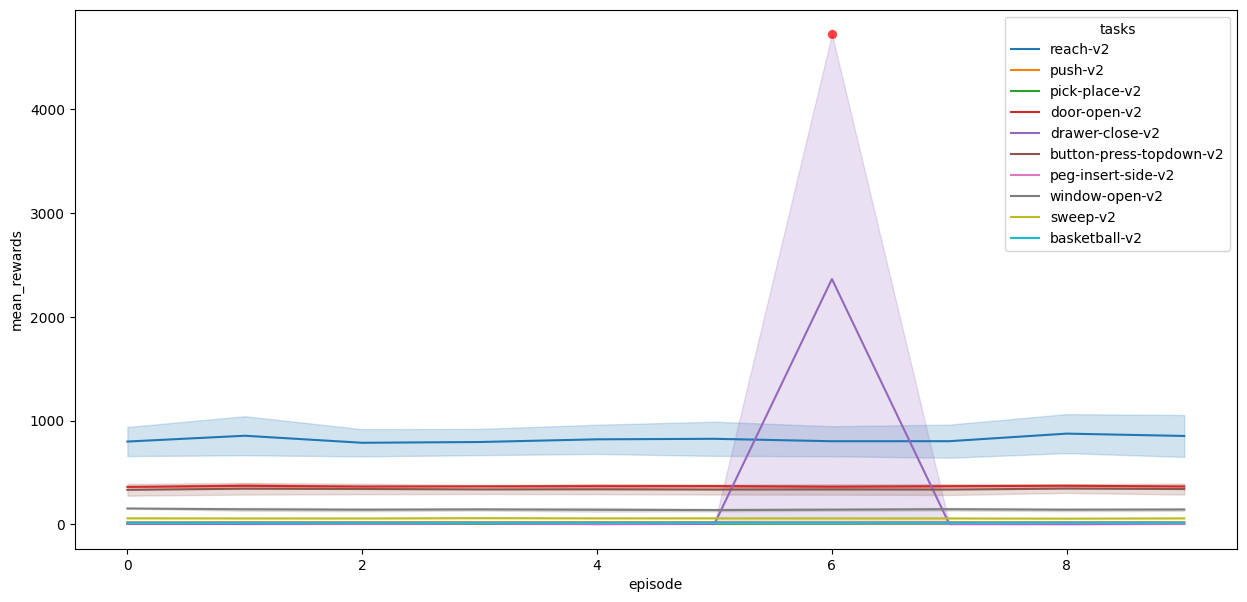

In [120]:
df= pd.concat([results1, results2])

fig, ax = plt.subplots(figsize = (15, 7))
reward_plot = sns.lineplot(
    data = df,
    x = 'episode',
    y = 'mean_rewards',
    hue = 'tasks',
)

successes = sns.scatterplot(
    data = df.query('successes==1'),
    x = 'episode',
    y = 'mean_rewards',
    legend = False,
    c = 'red',
    s = 50,
    alpha = 0.75
)
fig.savefig('./test.png')

In [90]:
pd.DataFrame(
    rewards.detach().cpu().numpy().tolist(),
    index = train_tasks
    )\
    .melt(
        var_name='episode',
        value_name = 'mean_rewards',
        ignore_index=False
    )

,episode,mean_rewards
reach-v2,0,938.695923
push-v2,0,21.402735
pick-place-v2,0,7.835010
door-open-v2,0,358.675873
drawer-close-v2,0,8.519575
...,...,...
button-press-topdown-v2,9,287.688568
peg-insert-side-v2,9,8.170078
window-open-v2,9,156.479721
sweep-v2,9,58.909695


In [76]:
pd.DataFrame(
        list(
            zip(
                train_tasks,
                successes.detach().cpu().numpy(),
                rewards.detach().cpu().numpy(),
                )
            )
        )

,0,1,2
0,reach-v2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[938.6959, 1042.6333, 918.0484, 920.5774, 960...."
1,push-v2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[21.402735, 23.900784, 23.281101, 22.957527, 2..."
2,pick-place-v2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[7.83501, 7.6970553, 7.617082, 7.8486915, 7.73..."
3,door-open-v2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[358.67587, 391.54025, 369.55655, 365.2108, 38..."
4,drawer-close-v2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.519575, 6.1392574, 9.467706, 16.077717, 4.3..."
5,button-press-topdown-v2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[277.26276, 287.666, 291.32184, 293.1018, 291...."
6,peg-insert-side-v2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.084275, 13.666099, 7.8466916, 9.388471, 8.0..."
7,window-open-v2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[151.12157, 160.08109, 156.43967, 156.04756, 1..."
8,sweep-v2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[59.426773, 58.604877, 59.04734, 62.124165, 58..."
9,basketball-v2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[14.382732, 15.031137, 14.161661, 15.216071, 1..."


<Axes: xlabel='task', ylabel='mean_reward'>

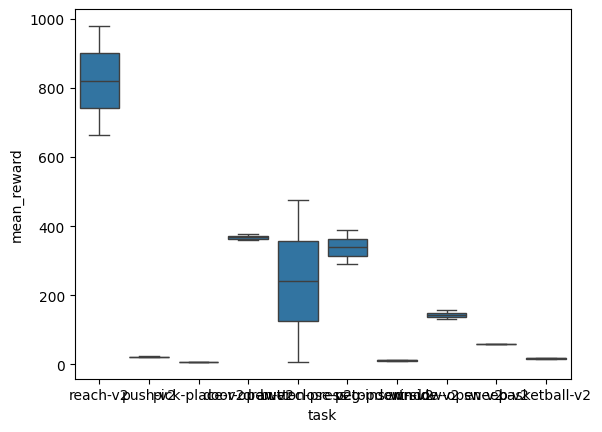

In [75]:
import seaborn as sns
combined = pd.concat([results1, results2])
sns.boxplot(
    data = combined,
    x = 'task',
    y = 'mean_reward'
)

In [ ]:
ml10 = metaworld.ML10()

In [56]:
successes.mean(dim = 1).detach().cpu().numpy()

array([0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  ],
      dtype=float32)

In [66]:
def clean_results(task_list, successes, rewards):
    return pd.DataFrame(
        list(
            zip(
                task_list,
                successes.mean(dim = 1).detach().cpu().numpy(),
                rewards.mean(dim = 1).detach().cpu().numpy(),
                rewards.std(dim = 1).detach().cpu().numpy()
                )
            )
        ).rename(columns = {0:'task', 1:'success_rate', 2:'mean_reward', 3: 'std_reward'})

In [65]:

pd.DataFrame(
    list(
        zip(
            list(ml10.train_classes.keys()),
            successes.mean(dim = 1).detach().cpu().numpy(),
            rewards.mean(dim = 1).detach().cpu().numpy(),
            rewards.std(dim = 1).detach().cpu().numpy()
        )
    )
).rename(columns = {0:'task', 1:'success_rate', 2:'mean_reward', 3: 'std_reward'})

,task,success_rate,mean_reward,std_reward
0,reach-v2,0.00,718.045532,14.925568
1,push-v2,0.00,20.615723,0.828136
2,pick-place-v2,0.00,6.862331,0.456922
3,door-open-v2,0.00,348.995239,4.861429
4,drawer-close-v2,0.25,1192.613770,2381.198975
5,button-press-topdown-v2,0.00,462.184479,4.563837
6,peg-insert-side-v2,0.00,8.692009,0.764500
7,window-open-v2,0.00,155.165466,6.694112
8,sweep-v2,0.00,58.787682,1.085891
9,basketball-v2,0.00,9.928297,3.534458


In [58]:
list(zip(list(ml10.train_classes.keys()), rewards.mean(dim = 1).detach().cpu().numpy()/500))

[('reach-v2', 1.4360911),
 ('push-v2', 0.041231446),
 ('pick-place-v2', 0.013724662),
 ('door-open-v2', 0.6979905),
 ('drawer-close-v2', 2.3852274),
 ('button-press-topdown-v2', 0.924369),
 ('peg-insert-side-v2', 0.017384019),
 ('window-open-v2', 0.31033093),
 ('sweep-v2', 0.11757536),
 ('basketball-v2', 0.019856595)]

In [31]:
rewards

tensor([[6.6431e+02, 6.4147e+02, 6.4274e+02, 6.3764e+02, 6.5756e+02, 6.6453e+02,
         6.4782e+02, 6.4171e+02, 6.4809e+02, 6.4067e+02],
        [2.3128e+01, 2.3618e+01, 2.4476e+01, 2.3435e+01, 2.4426e+01, 2.3478e+01,
         2.2808e+01, 2.4285e+01, 2.4253e+01, 2.3131e+01],
        [5.9328e+00, 7.3818e+00, 7.5251e+00, 7.6199e+00, 7.5977e+00, 7.5671e+00,
         7.5534e+00, 7.3842e+00, 7.5432e+00, 7.5635e+00],
        [3.6226e+02, 3.5100e+02, 3.5416e+02, 3.4139e+02, 3.5593e+02, 3.5261e+02,
         3.5385e+02, 3.4589e+02, 3.4604e+02, 3.5207e+02],
        [1.3906e+00, 1.7032e+00, 9.8807e-01, 9.5439e-01, 1.0338e+00, 4.6421e+03,
         1.2772e+00, 9.4042e-01, 1.5033e+00, 1.4298e+00],
        [3.7331e+02, 3.6192e+02, 3.6572e+02, 3.9181e+02, 3.7502e+02, 3.7193e+02,
         3.7246e+02, 3.6910e+02, 3.7965e+02, 3.7528e+02],
        [3.2166e+01, 1.6240e+01, 1.7430e+01, 4.0836e+01, 3.9391e+01, 2.0910e+01,
         2.5861e+01, 2.8400e+01, 2.9613e+01, 3.3399e+01],
        [1.8301e+02, 2.1034

In [3]:
from models.combined_actor_critic import ActorCritic

## RL2 agent
ac = ActorCritic(policy_net, encoder_net)

class rl2_agent:
    """
    Simple agent wrapper to run RL2 eval
    """
    def __init__(self, network):
        self.actor_critic = network

    def act(self, obs, latent, task = None, belief = None):
        return self.actor_critic.act(obs, latent, task, belief)
    
agent = rl2_agent(ac)

In [4]:
from environments.parallel_envs import make_vec_envs
## instead, create varibad env
## create n subtasks for each task to eval (for simplicity set n = 1)
num_processes = 10
exploration_iters = 1
eval_iters = 1
envs = make_vec_envs(
    'CustomML10-v2',
    seed = 73,
    num_processes=num_processes,
    episodes_per_task = exploration_iters + eval_iters,
    normalise_rew=False,
    ret_rms = False,
    add_done_info=True,
    tasks = None,
    gamma = 0.99,
    device=device
)
## try k exploration iterations without resetting hidden state, save final hidden states

## run j evaluation iterations where hidden state is reset to final hidden state from exploration iter

## save eval as eval_iter, task, mean_reward, std_reward, success

In [5]:
obs = envs.reset()

In [6]:
with torch.no_grad():
    _, latent_mean, latent_logvar, hidden_state = agent.actor_critic.encoder.prior(num_processes)
    latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim=-1)

In [7]:
obs.size()

torch.Size([10, 40])

In [8]:
with torch.no_grad():
    value, action = agent.act(obs, latent)

In [9]:
action.squeeze().size()

torch.Size([10, 4])

In [16]:
action.permute(0,2,1).size()

torch.Size([1, 4, 10])

In [18]:
envs.close()

KeyboardInterrupt: 

In [17]:
out = envs.step(action.permute(0,2,1))

KeyboardInterrupt: 

In [26]:
## do explore
obs = envs.reset()
for i in range(exploration_iters * 500):
    action = agent.act(obs)
    envs.step(torch.tensor([1,1,1,1]).to(device))

KeyboardInterrupt: 

In [13]:



results = {
    task:{
        'reward_mean': 0,
        'reward_std': 0,
        'successes' :0
    } for task in tasks
}
with torch.no_grad():
    _, latent_mean, latent_logvar, hidden_state = agent.actor_critic.encoder.prior(num_processes)
    latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim=-1)
    
while envs.get_env_attr('cur_step') < envs.get_env_attr('steps_limit'):

    obs = envs.reset() # we reset all at once as metaworld is time limited
    current_task = tasks[envs.get_env_attr('cur_seq_idx')]
    episode_reward = []
    successes = []
    done = [False for _ in range(num_eval)]

    ## TODO: determine how frequently to get prior - do at start of each episode for now
    # with torch.no_grad():
    #     _, latent_mean, latent_logvar, hidden_state = agent.actor_critic.encoder.prior(num_eval)
    #     latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim=-1)


    while not all(done):
        with torch.no_grad():
            _, action = agent.act(obs, latent, None, None)
        next_obs, reward, done, info = envs.step(action)
        assert all(done) == any(done), "Metaworld envs should all end simultaneously"

        obs = next_obs

        ## combine all rewards
        episode_reward.append(reward)
        # if we succeed at all then the task is successful
        successes.append(torch.tensor([i['success'] for i in info]))

        with torch.no_grad():
            _, latent_mean, latent_logvar, hidden_state = agent.actor_critic.encoder(action, obs, reward, hidden_state, return_prior = False)
            latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim = -1)[None,:]

    ## log the results here
    rewards_to_log = torch.stack(episode_reward).squeeze().cpu()
    results[current_task]['reward_mean'] = rewards_to_log.mean().numpy()
    results[current_task]['reward_std'] = rewards_to_log.std().numpy()
    results[current_task]['successes'] = (torch.stack(successes).max(0)[0].sum() / num_eval).numpy()


AttributeError: 'SubprocVecEnv' object has no attribute 'reset_mdp'

In [4]:
import metaworld
from environments.custom_env_utils import prepare_base_envs, prepare_parallel_envs

ML10 = metaworld.ML10()
# get task names
train_tasks = list(ML10.train_classes.keys())
test_tasks = list(ML10.test_classes.keys())


# training_envs = prepare_base_envs(train_tasks, benchmark=ML10)
# par_training_envs = prepare_parallel_envs(training_envs, 500, 10, device)

In [30]:
training_envs = prepare_base_envs(train_tasks, benchmark=ML10, task_set='train')
par_training_envs = prepare_parallel_envs(training_envs, 500, 10, device)

In [69]:
def eval_rl2(agent, tasks, benchmark, task_set, num_eval):
    raw_envs = prepare_base_envs(tasks, benchmark, task_set)
    envs = prepare_parallel_envs(
        raw_envs,
        500, 
        num_eval,
        device
    )
    results = {
        task:{
            'reward_mean': 0,
            'reward_std': 0,
            'successes' :0
        } for task in tasks
    }
    while envs.get_env_attr('cur_step') < envs.get_env_attr('steps_limit'):

        obs = envs.reset() # we reset all at once as metaworld is time limited
        current_task = tasks[envs.get_env_attr('cur_seq_idx')]
        episode_reward = []
        successes = []
        done = [False for _ in range(num_eval)]

        ## TODO: determine how frequently to get prior - do at start of each episode for now
        with torch.no_grad():
            _, latent_mean, latent_logvar, hidden_state = agent.actor_critic.encoder.prior(num_eval)
            latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim=-1)


        while not all(done):
            with torch.no_grad():
                _, action = agent.act(obs, latent, None, None)
            next_obs, reward, done, info = envs.step(action)
            assert all(done) == any(done), "Metaworld envs should all end simultaneously"

            obs = next_obs

            ## combine all rewards
            episode_reward.append(reward)
            # if we succeed at all then the task is successful
            successes.append(torch.tensor([i['success'] for i in info]))

            with torch.no_grad():
                _, latent_mean, latent_logvar, hidden_state = agent.actor_critic.encoder(action, obs, reward, hidden_state, return_prior = False)
                latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim = -1)[None,:]

        ## log the results here
        rewards_to_log = torch.stack(episode_reward).squeeze().cpu()
        results[current_task]['reward_mean'] = rewards_to_log.mean().numpy()
        results[current_task]['reward_std'] = rewards_to_log.std().numpy()
        results[current_task]['successes'] = (torch.stack(successes).max(0)[0].sum() / num_eval).numpy()

    cleaned_results = clean_results(results)
    return cleaned_results

    # cleaned_results.to_csv(logging_path)

def clean_results(results_dict):
    df = pd.DataFrame(results_dict).T.reset_index().rename(columns={'index':'task'})
    df.loc[:,'task'] = df.loc[:,'task'].astype('category')
    df.loc[:,'reward_mean'] = df.loc[:,'reward_mean'].astype('float')
    df.loc[:,'reward_std'] = df.loc[:,'reward_std'].astype('float')
    df.loc[:,'successes'] = df.loc[:,'successes'].astype('float')
    return df
    

In [64]:
test_processes = 32 # samples per task to eval
raw_test_envs = prepare_base_envs(test_tasks, benchmark=ML10, task_set='test')
test_envs = prepare_parallel_envs(
    raw_test_envs,
    500,
    test_processes,
    device
)

res = {task: {'reward_mean':[], 'reward_std':[], 'successes':[]} for task in test_tasks}
while test_envs.get_env_attr('cur_step') < test_envs.get_env_attr('steps_limit'):

        obs = test_envs.reset() # we reset all at once as metaworld is time limited
        current_task = test_tasks[test_envs.get_env_attr('cur_seq_idx')] ## TODO: make test_tasks a parameter
        episode_reward = []
        successes = []
        done = [False for _ in range(test_processes)]

        ## TODO: determine how frequently to get prior - do at start of each episode for now
        with torch.no_grad():
            _, latent_mean, latent_logvar, hidden_state = agent.actor_critic.encoder.prior(test_processes)
            latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim=-1)


        while not all(done):
            with torch.no_grad():
                _, action = agent.act(obs, latent, None, None)
            next_obs, reward, done, info = test_envs.step(action)
            assert all(done) == any(done), "Metaworld envs should all end simultaneously"

            obs = next_obs

            ## combine all rewards
            episode_reward.append(reward)
            # if we succeed at all then the task is successful
            successes.append(torch.tensor([i['success'] for i in info]))

            with torch.no_grad():
                _, latent_mean, latent_logvar, hidden_state = agent.actor_critic.encoder(action, obs, reward, hidden_state, return_prior = False)
                latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim = -1)[None,:]

        ## log the results here
        rewards_to_log = torch.stack(episode_reward).squeeze().cpu()
        res[current_task]['reward_mean'] = rewards_to_log.mean().numpy()
        res[current_task]['reward_std'] = rewards_to_log.std().numpy()
        res[current_task]['successes'] = (torch.stack(successes).max(0)[0].sum() / test_processes).numpy()

# # tidy up results
# for task in test_tasks:
#      res[task]['rewards'] = res[task]['rewards'].squeeze()




In [65]:
df = pd.DataFrame(res).T.reset_index().rename(columns={'index':'task'})
df.loc[:,'task'] = df.loc[:,'task'].astype('category')
df.loc[:,'reward_mean'] = df.loc[:,'reward_mean'].astype('float')
df.loc[:,'reward_std'] = df.loc[:,'reward_std'].astype('float')
df.loc[:,'successes'] = df.loc[:,'successes'].astype('float')

In [73]:
results = eval_rl2(agent, train_tasks, ML10, 'train', 32)
results

,task,reward_mean,reward_std,successes
0,reach-v2,1.667807,1.116329,0.0
1,push-v2,0.009024,0.010942,0.0
2,pick-place-v2,0.00419,0.003915,0.0
3,door-open-v2,0.778715,0.198087,0.0
4,drawer-close-v2,6.423393,4.784329,0.84375
5,button-press-topdown-v2,0.979794,0.175235,0.0
6,peg-insert-side-v2,0.007734,0.003592,0.0
7,window-open-v2,0.710183,0.632933,0.1875
8,sweep-v2,0.031412,0.027398,0.0
9,basketball-v2,0.00508,0.007888,0.0


<Axes: xlabel='reward_std', ylabel='reward_mean'>

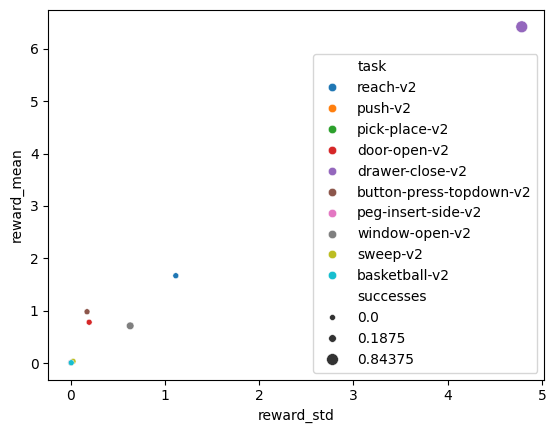

In [77]:
import seaborn as sns

sns.scatterplot(
    data = results,
    x = 'reward_std',
    y = 'reward_mean',
    hue='task',
    size = 'successes'
)

<Axes: xlabel='task', ylabel='successes'>

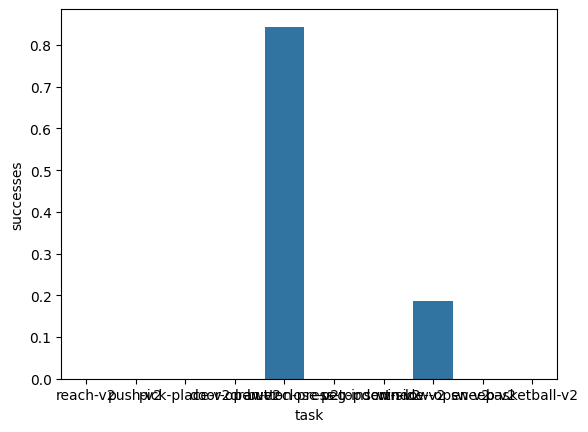

In [75]:
sns.barplot(
    data = results,
    x = 'task',
    y = 'successes'
)

In [ ]:
def evaluate(raw_test_envs, test_processes = 10):
    start_time = time.time() # use this in logger?
    # current_task_name = self.env_id_to_name[current_task + 1]
    
    ## num runs given by test_processes
    test_envs = prepare_parallel_envs(
        raw_test_envs, 
        500,
        test_processes, 
        device
    )

    # record outputs
    # task_rewards = {
    #     task_name: [] for task_name in self.task_names
    # }

    # task_successes = {
    #     task_name: [] for task_name in self.task_names
    # }

    while test_envs.get_env_attr('cur_step') < test_envs.get_env_attr('steps_limit'):

        obs = test_envs.reset() # we reset all at once as metaworld is time limited
        episode_reward = []
        successes = []
        done = [False for _ in range(test_processes)]

        ## TODO: determine how frequently to get prior - do at start of each episode for now
        with torch.no_grad():
            _, latent_mean, latent_logvar, hidden_state = self.agent.actor_critic.encoder.prior(test_processes)
            latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim=-1)


        while not all(done):
            with torch.no_grad():
                _, action = self.agent.act(obs, latent, None, None)
            next_obs, reward, done, info = test_envs.step(action)
            assert all(done) == any(done), "Metaworld envs should all end simultaneously"

            obs = next_obs

            ## combine all rewards
            episode_reward.append(reward)
            # if we succeed at all then the task is successful
            successes.append(torch.tensor([i['success'] for i in info]))

            with torch.no_grad():
                _, latent_mean, latent_logvar, hidden_state = self.agent.actor_critic.encoder(action, obs, reward, hidden_state, return_prior = False)
                latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim = -1)[None,:]

        ## log the results here
        task_rewards[self.env_id_to_name[test_envs.get_env_attr('cur_seq_idx')]] = torch.stack(episode_reward).cpu()
        task_successes[self.env_id_to_name[test_envs.get_env_attr('cur_seq_idx')]] = torch.stack(successes).max(0)[0].sum() #/ test_processes

    end_time = time.time()
    self.logger.add_tensorboard('current_task', current_task, eps)

    #log rewards, successes to tensorboard
    ## TODO: is there a neater way? e.g. log each of these under the same board
    self.logger.add_multiple_tensorboard('mean_task_rewards', {name: torch.mean(rewards) for name, rewards in task_rewards.items()}, eps)
    self.logger.add_multiple_tensorboard('task_successes', task_successes, eps)

    # log reward quantiles, successes to csv
    # ['training_task', 'evaluation_task', 'successes', 'result_mean', *['q_' + str(q) for q in self.logging_quantiles], 'episode']
    for task in self.task_names:
        reward_quantiles = torch.quantile(
            task_rewards[task],
            torch.tensor(self.quantiles)
        ).numpy().tolist()

        to_write = (
            current_task_name,
            task,
            task_successes[task].numpy(),
            test_processes, # record number of eval tasks per env
            task_rewards[task].mean().numpy(),
            *reward_quantiles,
            eps
        )
        self.logger.add_csv(to_write)
    
    print(f"eval completed in {end_time - start_time}")
    test_envs.close()